In [1]:
import numpy as np
import tools21cm as t2c
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as pear
import sys
from sklearn.decomposition import FastICA, PCA

In [2]:
in_path_fg = "fits_files/"
in_path_cs = "Boxes/"

output_path = "Results/"
fname_all = "test_filename"

fname_foreground = "new_fg_all"
fname_cs = "test"


fname_foreground = "fg_all"
fname_cs = "test"

indata_fg = fits.getdata(in_path_fg+fname_foreground+'.fits').T
indata_cs = fits.getdata(in_path_cs+fname_cs+'.fits')

#noise = fits.getdata('fits_files/Noise_10000.fits').T
#1000 hours
noise = fits.getdata(r'fits_files/noise_108.000MHz_210.300MHz_SKA_SKA_central_area_EOR0_0128_3.0_1000h_K.fits')
#100 hours 
#noise = fits.getdata('fits_files/Noise_100.fits').T
#residual
res = fits.getdata('Results/ZT0.msn_image_ncomp_3_FastICA_residual.fits')

indata_cs = indata_cs/1000

no_sl = 342
box_dims = 128

## 1D Power Spectrum

In [3]:
#use 8.1MHZ coeval cube from lightcone, this is 27 slices of lightcone
def error(data):
    sigma = []
    for i in range(13):
        sig = data[24*i:24*(i+1),:,:]
        ps, ks, n_samp = t2c.power_spectrum_1d(sig, kbins=10, box_dims = box_dims, return_n_modes = True)
        si =  (ps*ks**3 / (2*np.pi**2))/(np.sqrt(n_samp))
        sigma.append(si)
    return sigma


def power_1D(data):
    box_dims = 128
    plt.figure(figsize=(6,6))
    color_palette = plt.cm.Blues(np.linspace(0.2,1,13))
    sigma = error(data)
    for i in range(13):
        sig = data[24*i:24*(i+1),:,:]
        err = sigma[i]
        ps, ks = t2c.power_spectrum_1d(sig, kbins=10, box_dims = box_dims)
        plt.loglog(ks, (ps*ks**3 / (2*np.pi**2)),
                   color = color_palette[i],label = 'frequency =' + str(round( 114.25 - 4.05 +(8.0*i),1)) + 'MHz') #change frequencies
        plt.errorbar(ks, (ps*ks**3 / (2*np.pi**2)), yerr = err, fmt ='none', capsize = 3, ecolor = color_palette[i])
        plt.xlabel('k (Mpc$^{-1}$)')
        plt.ylabel('P(k) k$^{3}$/$(2\pi^2)\ [K^2]$')
        plt.legend(fontsize =8)
        


# problem with error bars is that it is a loglog plot, higher k with higher frequencies have higher values but log distrupts that

Text(0.5, 1.0, 'Spherically average power spectrum for residual')

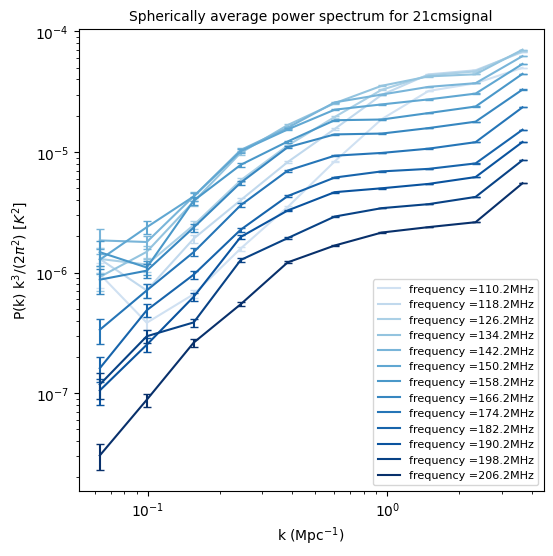

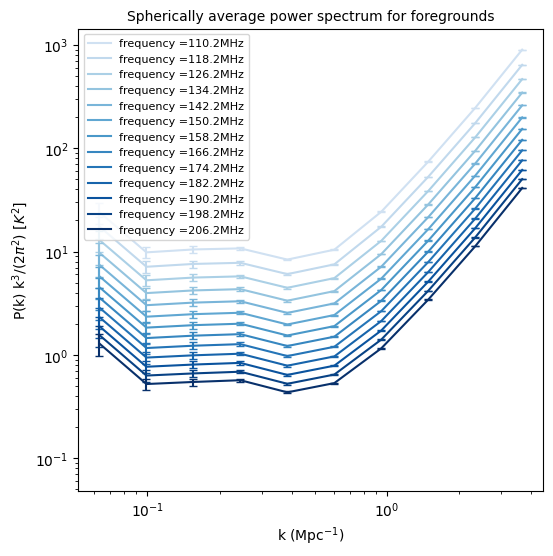

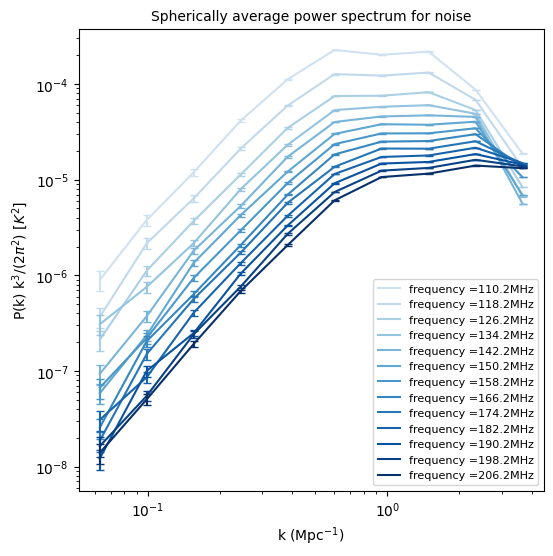

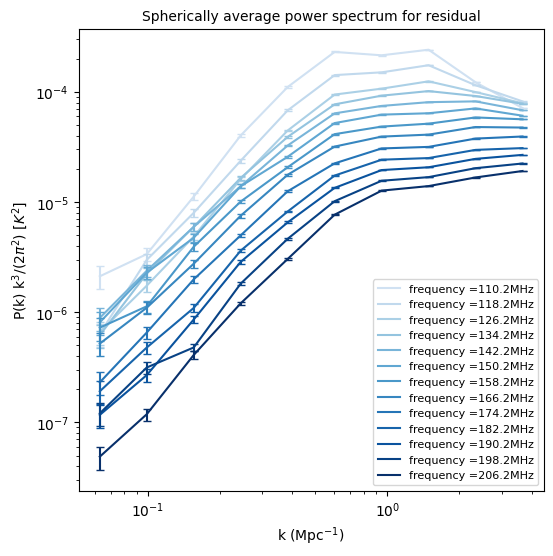

In [4]:
#21cmsignal
power_1D(indata_cs)
plt.title('Spherically average power spectrum for 21cmsignal', fontsize=10)
#plt.savefig('images/powerspectrum for lightcone points')

power_1D(indata_fg)
plt.title('Spherically average power spectrum for foregrounds', fontsize=10)
#plt.savefig('images/powerspectrum for foregrounds points')

power_1D(noise)
plt.title('Spherically average power spectrum for noise', fontsize=10)
#plt.savefig('images/powerspectrum for noise')

power_1D(res)
plt.title('Spherically average power spectrum for residual', fontsize=10)
#plt.savefig('images/powerspectrum for residual')


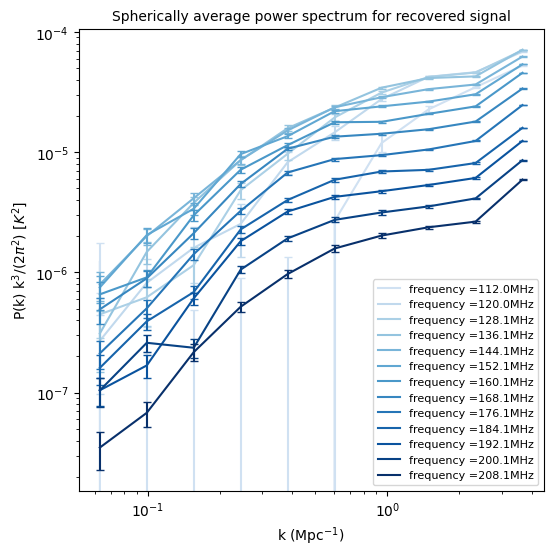

In [5]:
plt.figure(figsize=(6,6))
color_palette = plt.cm.Blues(np.linspace(0.2,1,13))
sigma_res = error(res)
sigma_noise = error(noise)
for i in range(13):
    residual = res[24*i:24*(i+1),:,:]
    ps_res, ks_res = t2c.power_spectrum_1d(residual, kbins=10, box_dims = box_dims)
    noise1 = noise[24*i:24*(i+1),:,:]
    ps_no, ks_no = t2c.power_spectrum_1d(noise1, kbins=10, box_dims = box_dims)

    #recovered signal
    #dosen't matter what ks you use because both values are the same
    ps = ps_res - ps_no
    ks =ks_res

    sigma_square = sigma_res[i]**2 + sigma_noise[i]**2
    sigma = np.sqrt(sigma_square)

    err = sigma

    plt.title('Spherically average power spectrum for recovered signal', fontsize=10)
    plt.loglog(ks_res, (ps*ks**3 / (2*np.pi**2)),color = color_palette[i],label = 'frequency =' + \
               str(round(4.05 + 108 +(8.0*i),1)) + 'MHz')
    plt.errorbar(ks, (ps*ks**3 / (2*np.pi**2)), yerr = err, fmt ='none', capsize =3, ecolor = color_palette[i])
    plt.xlabel('k (Mpc$^{-1}$)')
    plt.ylabel('P(k) k$^{3}$/$(2\pi^2)\ [K^2]$')
    plt.legend(fontsize =8)
#plt.savefig('images/powerspectrum for recovered signal')

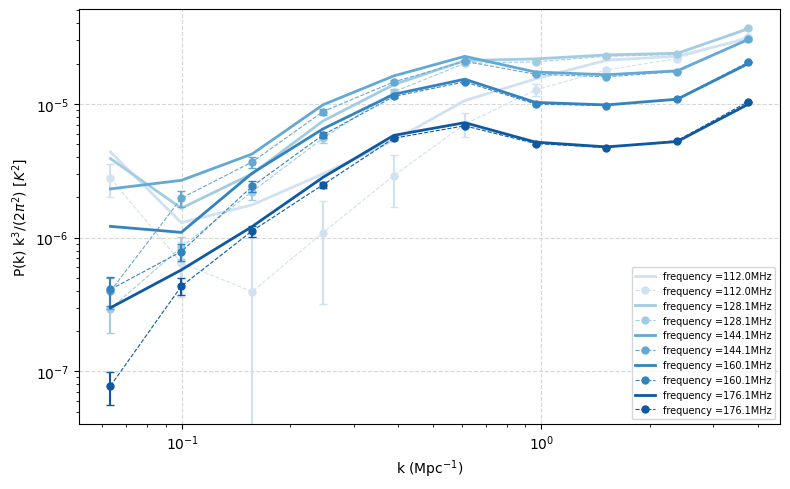

In [6]:
plt.figure(figsize=(8,5))
color_palette = plt.cm.Blues(np.linspace(0.2,1,6))
#errors for residual and noise
def error(data):
    sigma = []
    for i in range(6):
        sig = data[48*i:48*(i+1),:,:]
        ps, ks, n_samp = t2c.power_spectrum_1d(sig, kbins=10, box_dims = box_dims, return_n_modes = True)
        si =  (ps*ks**3 / (2*np.pi**2))/(np.sqrt(n_samp))
        sigma.append(si)
    return sigma
sigma_res = error(res)
sigma_noise = error(noise)

different = []

for i in range(5):
    #lightcone
    #i = i +1
    sig = indata_cs[48*i:48*(i+1),:,:]
    psl, ksl = t2c.power_spectrum_1d(sig, kbins=10, box_dims = box_dims)
    plt.loglog(ksl, (psl*ksl**3 / (2*np.pi**2)),
            color = color_palette[i],label = 'frequency =' + str(round(4.05 + 108 +(16*i),1)) + 'MHz', linewidth = 2)

    
    residual = res[48*i:48*(i+1),:,:]
    ps_res, ks_res = t2c.power_spectrum_1d(residual, kbins=10, box_dims = box_dims)
    
    noise1 = noise[48*i:48*(i+1),:,:]
    ps_no, ks_no = t2c.power_spectrum_1d(noise1, kbins=10, box_dims = box_dims)
    #recovered signal
    #dosen't matter what ks you use because both values are the same
    ps = ps_res - ps_no
    #checked ks_res = ks_no so using ks_res for k space
    ks = ks_res
    #error bars
    err = np.sqrt(sigma_res[i]**2 + sigma_noise[i]**2)

    diff = np.abs((ps - psl)/(psl))*100 #difference as a percentage

    #plt.title('1D power spectrum for 21cmsignal and recovered signal', fontsize=10)
    plt.loglog(ks, (ps*ks**3 / (2*np.pi**2)) , '.--', markersize =10,linewidth = 0.8, color = color_palette[i],
               label = 'frequency =' + str(round(4.05 + 108 +(16*i),1)) + 'MHz')
    
    plt.errorbar(ks, (ps*ks**3 / (2*np.pi**2)), yerr = err, fmt ='none', capsize = 3, ecolor = color_palette[i])
    plt.xlabel('k (Mpc$^{-1}$)')
    plt.ylabel('P(k) k$^{3}$/$(2\pi^2)\ [K^2]$')
    plt.legend(fontsize = 7)
    plt.grid(True, linestyle= '--', alpha = 0.5)
    plt.tight_layout()

    different.append(diff) 
plt.rcParams.update({'font.size' : 10})

plt.savefig('Submit/powerspectrum for lightcone and recovered signal.png')

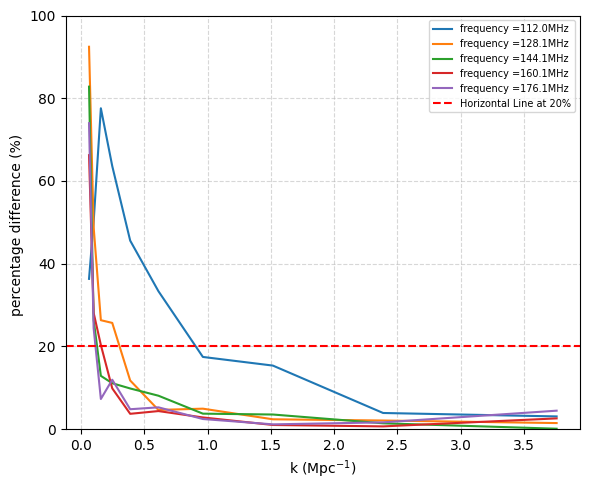

In [7]:
plt.figure(figsize = (6,5))
for i in range(5):
    #i = i+1
    point = different[i]
    plt.plot(ks,point,label = 'frequency =' + str(round(4.05 + 108 +(16*i),1)) + 'MHz')
    plt.legend(fontsize = 7)
    plt.grid(True, linestyle= '--', alpha = 0.5)
    plt.xlabel('k (Mpc$^{-1}$)')
    plt.ylabel('percentage difference (%) ')
    plt.tight_layout()
    #plt.title('Percentage difference of powerspectrum 1D', fontsize =10 )
    plt.ylim(0,100)
plt.axhline(20, color ='r', linestyle ='--' , label = 'Horizontal Line at 20%')
plt.legend(fontsize = 7)
plt.rcParams.update({'font.size' : 10})
plt.savefig('Submit/Percentage difference of powerspectrum1D .png')

In [8]:
# not neccesary
plt.figure(figsize=(10,6))

frequency = [108,111,114,117,120,123]
different = []

for i in range(5):
    #lightcone
    sig = indata_cs[9*i:9*(i+1),:,:]
    
    psl, ksl = t2c.power_spectrum_1d(sig, kbins=10, box_dims = box_dims)
    
    #plt.loglog(ksl, (psl*ksl**3 / (2*np.pi**2)),
       #     color = color_palette[i],label = 'frequency =' + str(round(4.05 + 108 +(16*i),1)) + 'MHz', linewidth = 2)
    
    residual = res[9*i:9*(i+1),:,:]
    ps_res, ks_res = t2c.power_spectrum_1d(residual, kbins=10, box_dims = box_dims)
    
    noise1 = noise[9*i:9*(i+1),:,:]
    ps_no, ks_no = t2c.power_spectrum_1d(noise1, kbins=10, box_dims = box_dims)
    #recovered signal
    #dosen't matter what ks you use because both values are the same
    ps = ps_res - ps_no
    #checked ks_res = ks_no so using ks_res for k space
    ks =ks_res
    #error bars
    err = np.sqrt(sigma_res[i]**2 + sigma_noise[i]**2)

    diff = np.abs((ps - psl)/(psl))*100 #difference as a percentage

    #plt.title('1D power spectrum for 21cmsignal and recovered signal', fontsize=10)
    #plt.loglog(ks_res, (ps*ks**3 / (2*np.pi**2)) , '.--', markersize =10,linewidth = 0.8, color = color_palette[i],
               #label = 'frequency =' + str(round(4.05 + 108 +(16*i),1)) + 'MHz')
    
    #plt.errorbar(ks, (ps*ks**3 / (2*np.pi**2)), yerr = err, fmt ='none', capsize = 3, ecolor = color_palette[i])
    #plt.xlabel('k (Mpc$^{-1}$)')
    #plt.ylabel('P(k) k$^{3}$/$(2\pi^2)\ [K^2]$')
    #plt.legend(fontsize = 7)
    #plt.grid(True, linestyle= '--', alpha = 0.5)
    #plt.tight_layout()

    different.append(diff) 
#plt.savefig('images/powerspectrum for lightcone and recovered signal.png')

<Figure size 1000x600 with 0 Axes>

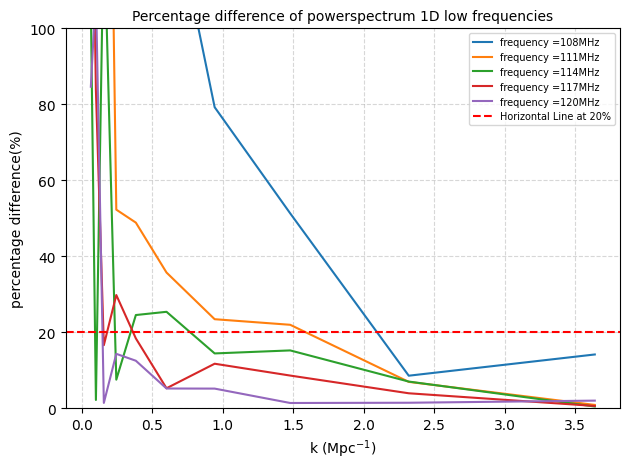

In [9]:
# showing the change in the percentage difference
for i in range(5):
    point = different[i]
    plt.plot(ks,point,label = 'frequency =' + str(frequency[i]) + 'MHz')
    plt.legend(fontsize = 7)
    plt.grid(True, linestyle= '--', alpha = 0.5)
    plt.xlabel('k (Mpc$^{-1}$)')
    plt.ylabel('percentage difference(%)')
    plt.tight_layout()
    plt.title('Percentage difference of powerspectrum 1D low frequencies', fontsize =10 )
    plt.ylim(0,100)
plt.axhline(20, color ='r', linestyle ='--' , label = 'Horizontal Line at 20%')
plt.legend(fontsize = 7)
#plt.savefig('images/Percentage difference of powerspectrum1D smaller coeval cube to show transition.png')
#used 3MHz cubes instead of 8Mhz cubes to show how the percentage difference is altered. Use thinner lightcone.

In [10]:
res1 = fits.getdata('Results/ZT0.msn_image_ncomp_1_FastICA_residual.fits')
res2 = fits.getdata('Results/ZT0.msn_image_ncomp_2_FastICA_residual.fits')
res3 = fits.getdata('Results/ZT0.msn_image_ncomp_3_FastICA_residual.fits')
res4 = fits.getdata('Results/ZT0.msn_image_ncomp_4_FastICA_residual.fits')
res5 = fits.getdata('Results/ZT0.msn_image_ncomp_5_FastICA_residual.fits')
res10 = fits.getdata('Results/ZT0.msn_image_ncomp_10_FastICA_residual.fits')
res20 = fits.getdata('Results/ZT0.msn_image_ncomp_20_FastICA_residual.fits')

<Figure size 800x500 with 0 Axes>

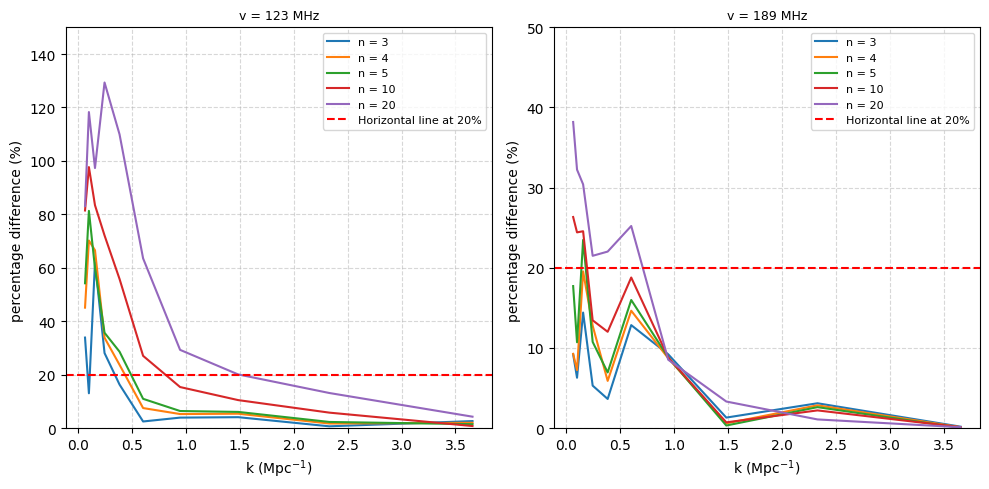

In [11]:
plt.figure(figsize=(8,5))
color_palette = plt.cm.Blues(np.linspace(0.2,1,6))
beg = 40
neg = 260

different = []

#lightcone
light1 = indata_cs[beg:beg+20,:,:]   #light frequency
light2 = indata_cs[neg:neg+20,:,:]
#power spectrum
psl1, ksl1 = t2c.power_spectrum_1d(light1, kbins=10, box_dims = box_dims)
psl2, ksl2 = t2c.power_spectrum_1d(light2, kbins=10, box_dims = box_dims)

#residual components
residual_11, residual_12 = res1[beg:beg+20,:,:], res1[neg:neg+20,:,:]
residual_21, residual_22 = res2[beg:beg+20,:,:], res2[neg:neg+20,:,:]
residual_31, residual_32 = res3[beg:beg+20,:,:], res3[neg:neg+20,:,:]
residual_41, residual_42 = res4[beg:beg+20,:,:], res4[neg:neg+20,:,:]
residual_51, residual_52 = res5[beg:beg+20,:,:], res5[neg:neg+20,:,:]
residual_61, residual_62 = res10[beg:beg+20,:,:], res10[neg:neg+20,:,:]  #n_comp  = 10
residual_71, residual_72 = res20[beg:beg+20,:,:], res20[neg:neg+20,:,:]  # n_comp = 20

ones = (residual_11, residual_21, residual_31, residual_41, residual_51, residual_61, residual_71)
twos = (residual_12, residual_22, residual_32, residual_42, residual_52, residual_62, residual_72)

ps_res_1 = [0]*7
ps_res_2 = [0]*7

ks_res_1 = [0]*7
ks_res_2 = [0]*7


for i in range(7):
    ps_res_1[i], ks_res_1[i]   =  t2c.power_spectrum_1d(ones[i], kbins=10, box_dims = box_dims)
    ps_res_2[i], ks_res_2[i]   =  t2c.power_spectrum_1d(twos[i], kbins=10, box_dims = box_dims)



noise1 = noise[beg:beg+20,:,:]
noise2 = noise[neg:neg+20,:,:]

ps_no1, ks_no1 = t2c.power_spectrum_1d(noise1, kbins=10, box_dims = box_dims)
ps_no2, ks_no2 = t2c.power_spectrum_1d(noise2, kbins=10, box_dims = box_dims)

ps_1 = ps_res_1 - ps_no1
ps_2 = ps_res_2 - ps_no2

ks_1 = ks_res_1
ks_2 = ks_res_2

diff_1 = np.abs((ps_1 - psl1)/(psl1))*100
diff_2 = np.abs((ps_2 - psl2)/(psl2))*100

compo = [1,2,3,4,5,10,20]

fig , (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

for i in range(5):
    ax1.plot(ks_1[i+2],diff_1[i+2], label = 'n = '+ str(compo[i+2]))
    ax1.set_ylim(0,150)
    ax1.set_xlabel('k (Mpc$^{-1}$)')
    ax1.set_ylabel('percentage difference (%) ')
    ax1.grid(True, linestyle= '--', alpha = 0.5)
    ax1.set_title('v = 123 MHz',fontsize = 9)
ax1.axhline(20, color ='r', linestyle ='--' , label = 'Horizontal line at 20%')
ax1.legend(fontsize = 8)


for i in range(5):
    ax2.plot(ks_2[i+2],diff_2[i+2], label = 'n = '+ str(compo[i+2]))
    ax2.set_ylim(0,50)
    ax2.set_xlabel('k (Mpc$^{-1}$)')
    ax2.set_ylabel('percentage difference (%) ')
    ax2.grid(True, linestyle= '--', alpha = 0.5)
    ax2.set_title('v = 189 MHz',fontsize = 9)
ax2.axhline(20, color ='r', linestyle ='--' , label = 'Horizontal line at 20%')
ax2.legend(fontsize = 8)

plt.tight_layout()
plt.rcParams.update({'font.size' : 10})
plt.savefig('Submit/Percentage difference of powerspectrum1D two different frequencies different components.png')

In [12]:
# n=1 and n=2 the percentage difference was too high and cannot be easily seen on the graph
# the number of components best suited depends on the scale,
# small k-space 3 components, large k - space 20 components for the frequency 186MHz
# for most frequencies n=3 components is the best components with the smallest errors

In [13]:
#residual
res1 = fits.getdata('Results/ZT0.msn_image_ncomp_1_FastICA_residual.fits')
res2 = fits.getdata('Results/ZT0.msn_image_ncomp_2_FastICA_residual.fits')
res3 = fits.getdata('Results/ZT0.msn_image_ncomp_3_FastICA_residual.fits')
res4 = fits.getdata('Results/ZT0.msn_image_ncomp_4_FastICA_residual.fits')
res5 = fits.getdata('Results/ZT0.msn_image_ncomp_5_FastICA_residual.fits')
res10 = fits.getdata('Results/ZT0.msn_image_ncomp_10_FastICA_residual.fits')
res20 = fits.getdata('Results/ZT0.msn_image_ncomp_20_FastICA_residual.fits')
#models
mod1 = fits.getdata('Results/ZT0.msn_image_ncomp_1_FastICA_model.fits')
mod2 = fits.getdata('Results/ZT0.msn_image_ncomp_2_FastICA_model.fits')
mod3 = fits.getdata('Results/ZT0.msn_image_ncomp_3_FastICA_model.fits')
mod4 = fits.getdata('Results/ZT0.msn_image_ncomp_4_FastICA_model.fits')
mod5 = fits.getdata('Results/ZT0.msn_image_ncomp_5_FastICA_model.fits')
mod10 = fits.getdata('Results/ZT0.msn_image_ncomp_10_FastICA_model.fits')
mod20 = fits.getdata('Results/ZT0.msn_image_ncomp_20_FastICA_model.fits')
#foregrounds
#1000 hours
noise = fits.getdata(r'fits_files/noise_108.000MHz_210.300MHz_SKA_SKA_central_area_EOR0_0128_3.0_1000h_K.fits')

In [14]:
#residuals
ress = [res1,res2,res3,res4,res5,res10,res20,indata_cs]

#models, the last value is the actual foreground
moda = [mod1,mod2,mod3,mod4,mod5,mod10,mod20,indata_fg]
# residual - noise
light = np.zeros((8,no_sl,128,128))
for i in range(7):
    residual = ress[i]
    lig = residual - noise
    light[i] = lig
light[7,:,:,:] = indata_cs

In [15]:
model_PS   = np.zeros((8,10))
model_K    = np.zeros((8,10))
fast_PS    = np.zeros((8,10))
fast_K     = np.zeros((8,10))

box_dims = 128
start = 160
end =  190
#frequency 160.5 MHz
for i in range(8):
    #model
    model = moda[i]
    siga = model[start:end, :, :]
    ps_mod, ks_mod = t2c.power_spectrum_1d(siga, kbins=10, box_dims = box_dims)
    model_PS[i] = ps_mod
    model_K[i] = ks_mod

for i in range(7):
    #residual
    residual = ress[i]
    sig = residual[start:end, :, :]
    ps_res, ks_res = t2c.power_spectrum_1d(sig, kbins=10, box_dims = box_dims)

    #noise
    noise1 = noise[start:end, :, :]
    ps_no, ks_no = t2c.power_spectrum_1d(noise1, kbins=10, box_dims = box_dims)

    #light
    psl = ps_res - ps_no
    #checked ks_res = ks_no so using ks_res for k space
    ksl =ks_res
    
    fast_PS[i]    = psl
    fast_K[i]     = ks_res
    
#The actual lightcone
sig = indata_cs[start:end, :, :]
ps_l, ks_l = t2c.power_spectrum_1d(sig, kbins=10, box_dims = box_dims)

#last element is the actual 21cmsignal, the same is for the foregrounds
fast_PS[7] = ps_l
fast_K[7]  = ks_l

#error bars

def error(data):
    sigma = []
    for i in range(8):
        #data
        residual = ress[i]
        sig = residual[start:end,:,:]
        ps, ks, n_samp = t2c.power_spectrum_1d(sig, kbins=10, box_dims = box_dims, return_n_modes = True)        
        si =  (ps*ks**3 / (2*np.pi**2))/(np.sqrt(n_samp))
        sigma.append(si)
    return sigma
sigma_res = error(ress)

#noise error is the same for all of the components
sigma_no = np.zeros((8,10))

slices = noise[start:end,:,:]
ps, ks, n_samp = t2c.power_spectrum_1d(sig, kbins=10, box_dims = box_dims, return_n_modes = True)        
si =  (ps*ks**3 / (2*np.pi**2))/(np.sqrt(n_samp))
for i in range(7):
    sigma_no[i] = si
sigma_no[7] = np.zeros(10)

#residual error
def error(data):
    sigma = []
    for i in range(8):
        #data
        residual = ress[i]
        sig = residual[start:end,:,:]
        ps, ks, n_samp = t2c.power_spectrum_1d(sig, kbins=10, box_dims = box_dims, return_n_modes = True)        
        si =  (ps*ks**3 / (2*np.pi**2))/(np.sqrt(n_samp))
        sigma.append(si)
    return sigma
sigma_res = error(ress)



In [16]:
print(model_PS[2] - model_PS[7])

[ 5.01437160e+01  1.02389638e+01  2.69972018e+00 -1.48657912e-01
  6.23787160e-02  2.35843923e-02  2.44642885e-03  1.41359109e-03
  1.56214036e-03  1.26389648e-03]


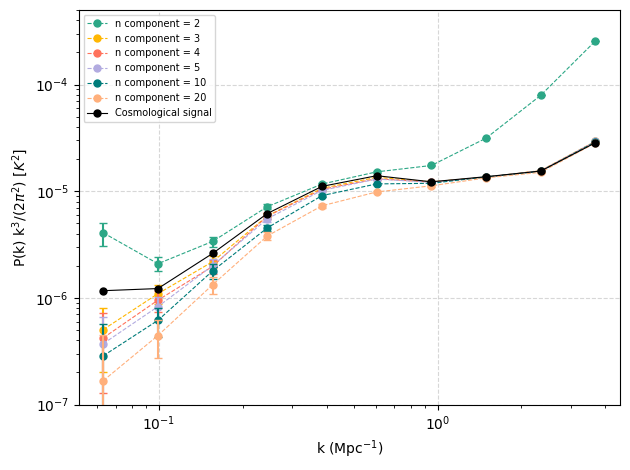

In [17]:
name = ['n component = 1','n component = 2','n component = 3','n component = 4','n component = 5',
        'n component = 10','n component = 20','Cosmological signal']

color_palette = ['#004c6d','#2ca786','#ffb703','#ff725c','#b2abe0','#007c7a','#ffb07c','k']
plt.figure()
#plt.title('Power spectrum for 21cmsignal using different components, v = 160.5 MHz', fontsize=10)
for i in range(7):
    i = i+1
    ps = fast_PS[i]
    ks = fast_K[i]
    err  = np.sqrt(sigma_res[i]**2 + sigma_no[i]**2)
    yerr = err
    if i <7:
        plt.loglog(ks, (ps*ks**3 / (2*np.pi**2)) , '.--', markersize = 10,linewidth = 0.8,color = color_palette[i],
                   label = name[i] )
        plt.errorbar(ks, (ps*ks**3 / (2*np.pi**2)), yerr = err, fmt ='none', capsize =3, ecolor = color_palette[i]) 
    else:
        plt.loglog(ks, (ps*ks**3 / (2*np.pi**2)) , '.-', markersize = 10,linewidth = 0.8,color = color_palette[i],
                label = name[i] )
    plt.xlabel('k (Mpc$^{-1}$)')
    plt.ylabel('P(k) k$^{3}$/$(2\pi^2)\ [K^2]$')
    plt.legend(fontsize = 7)
    plt.grid(True, linestyle= '--', alpha = 0.5)
    plt.ylim(10e-8,5e-4)
    plt.tight_layout()
plt.rcParams.update({'font.size' : 10})

#plt.savefig('Submit/Different number of components power spectrum 21cm signal, $v = 160 MHz$')
# for n component =1 the value is too far away from the actual 21cmsignal that it wasn't worth including.

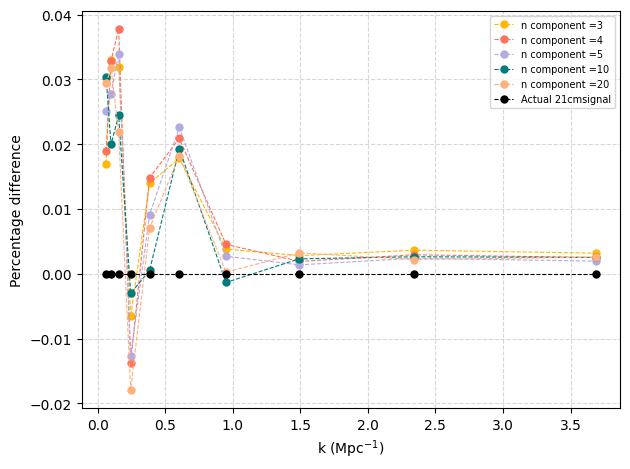

In [18]:
color_palette = ['#004c6d','#2ca786','#ffb703','#ff725c','#b2abe0','#007c7a','#ffb07c','k']
name = ['n component =1','n component =2','n component =3','n component =4','n component =5',
        'n component =10','n component =20','Actual 21cmsignal']
#plt.title('1D power spectrum', fontsize=10)
for i in range(6):
    ps = (model_PS[i+2]  - model_PS[7])/(model_PS[7]) *100
    ks = model_K[i+2] 

    plt.plot(ks,ps , '.--', markersize = 10,linewidth = 0.8, color = color_palette[i+2],
                   label = name[i+2] )
    
    plt.xlabel('k (Mpc$^{-1}$)')
    plt.ylabel('Percentage difference')
    plt.legend(fontsize = 7)
    plt.grid(True, linestyle= '--', alpha = 0.5)
    plt.tight_layout()
#plt.savefig('Submit/Percentage difference power spectrum, $v = 160 MHz$')


## Series of images

In [19]:
# find the correlations
corr = np.zeros(7)

for i in range(7):
    signal = light[7,60,:,:]
    iop =    light[i,60,:,:]
    first = signal
    second = iop
    corre = pear(first.flatten(),second.flatten())
    corr[i] = corre[0]
corr = np.around(corr,decimals = 3)
print(corr)

[0.129 0.656 0.97  0.945 0.928 0.896 0.787]


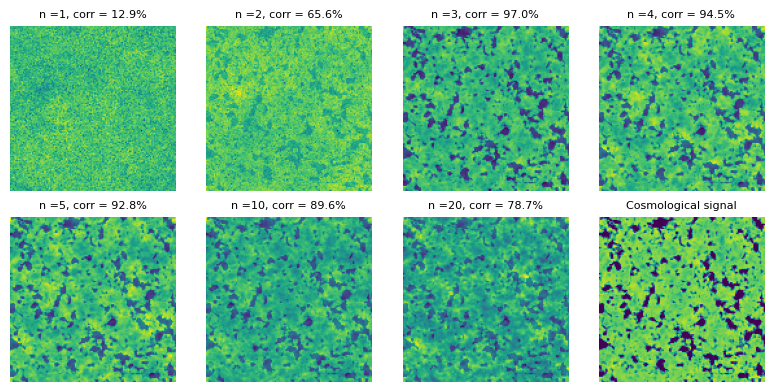

In [20]:
name = ['n =1','n =2','n =3','n =4','n =5',
        'n =10','n =20','Cosmological signal']

# frequency of 156MHz
fig, axes = plt.subplots(2,4,figsize = (8,4))
for i in range(8):
    if i <4:
        axes[0,i].imshow(light[i,60,:,:]) 
        axes[0,i].set_title(name[i]+', corr = ' + str(np.round(corr[i]*100,3)) +'%', fontsize=8)
        axes[0,i].axis('off')
    elif i <7:
        k = i-4
        axes[1,k].imshow(light[i,60,:,:]) 
        axes[1,k].set_title(name[i]+', corr = ' + str(np.round(corr[i]*100,3)) + '%',fontsize=8)
        axes[1,k].axis('off')
    else:
        k = i-4
        axes[1,k].imshow(light[i,60,:,:]) 
        axes[1,k].set_title(name[i],fontsize=8)
        axes[1,k].axis('off')

plt.tight_layout()
plt.savefig('Submit/residualAtDifferentComp.png')

## Power Spectrum 2D

In [21]:
in_path_fg = "fits_files/"
in_path_cs = "Boxes/"

output_path = "Results/"
fname_all = "test_filename"

fname_foreground = "new_fg_all"
fname_cs = "test"


fname_foreground = "fg_all"
fname_cs = "test"

indata_fg = fits.getdata(in_path_fg+fname_foreground+'.fits').T
indata_cs = fits.getdata(in_path_cs+fname_cs+'.fits')/1000
noise = fits.getdata('fits_files/noise_108.000MHz_210.300MHz_SKA_SKA_central_area_EOR0_0128_3.0_1000h_K.fits').T
exgal = fits.getdata(in_path_fg + 'egfg_max=24k.fits').T
free_free =  fits.getdata(in_path_fg + 'ff_test.fits').T
syn =  fits.getdata(in_path_fg + 'syn_test.fits').T
res = fits.getdata('Results/ZT0.msn_image_ncomp_3_FastICA_residual.fits')


no_sl = 342

In [22]:
def power_2(data,m):
    box_dims = 128
    p, k_los , k_perp = t2c.power_spectrum_2d(data[27*m:27*(m+1)], kbins = 10, box_dims = box_dims)
    #log and mean zeroed
    ps = np.log(p)
    #ps = ps - np.mean(ps)
    plt.pcolormesh(k_perp,k_los,ps , cmap = 'jet') 
    plt.xlabel('$k_{perp}$ (Mpc$^{-1}$)')
    plt.ylabel('$k_ {los}$ (Mpc$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')
    cbar = plt.colorbar(label = '$log(P(k))$')
    #plt.clim(-18,18) #fix the colour bar values

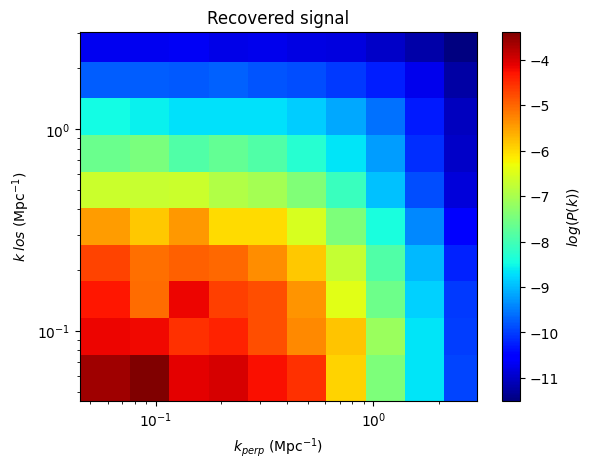

In [23]:
name = 'Recovered signal'
#n = 1
# signal, foreground and noise
#data =  light[n,:,:,:]
data = res - noise.T
m = 6 # coeval cube for lightcone of signal
power_2(data,m)
#name = '21cmsignal' # name of the signal
plt.title( name ) #pear = ' + str(corr[n]), fontsize=10)
plt.savefig('images/' + name +'.png')

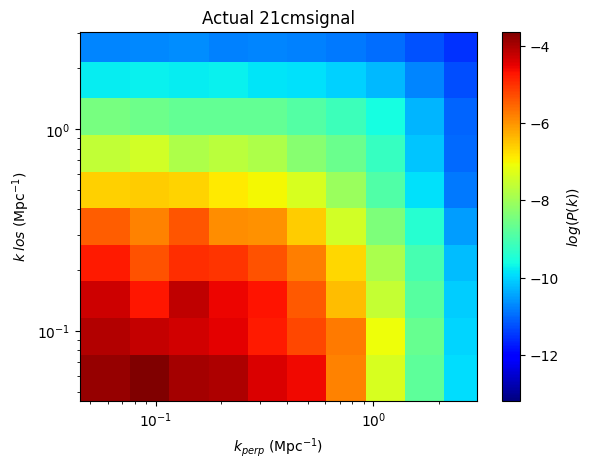

In [24]:
# series of images for the 2D cyclindrical power spectrum
name = 'Actual 21cmsignal' #'n = 1' #'Actual 21cmsignal'
n = 7
# signal, foreground and noise
data =  light[n,:,:,:]
m = 6 # coeval cube for lightcone of signal
power_2(data,m)
#name = '21cmsignal' # name of the signal
plt.title( name )#+ ', pear = ' + str(corr[n]))
plt.clim(-3,-12)
plt.savefig('images/ncomp/'+ name + '.png')
plt.rcParams.update({'font.size' : 10})
#frequency 160.6MHz